In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
class autoencoder:
    def __init__(self, d, n1):
        self.d_ = d
        self.n1_ = n1
        self.W1 = np.array([np.random.uniform(-6/np.sqrt(self.d_+self.n1_), 6/np.sqrt(self.d_+self.n1_), self.d_) for i in range(self.n1_)])
        self.W2 = np.array([np.random.uniform(-6/np.sqrt(self.d_+self.n1_), 6/np.sqrt(self.d_+self.n1_), self.n1_) for i in range(self.d_)])
        self.b1 = np.zeros((self.n1_,1))
        self.b2 = np.zeros((self.d_,1))
        self.onesb1 = None
        self.onesb2 = None
        self.t = 1
        for val in ("W1", "b1", "W2", "b2"):
            setattr(self, f"nu{val}", 0)
            setattr(self, f"h{val}", 0)
    
    def h1(self, a):
        return np.maximum(a,0)
    
    def h2(self, a):
        return 1/(1+np.exp(-a))
    
    def dh1(self, a):
        return np.where(a > 0, 1, 0)

    def dh2(self, a):
        return (1 - self.h2(a)) * self.h2(a)
#         return np.divide(np.exp(-a), (1+np.exp(-a))**2)
    
    def loss(self, Xbatch):
        Y = np.transpose(self.forward(Xbatch))
        loss = np.sum(np.multiply(Xbatch,np.log(Y)) + np.multiply(1-Xbatch, np.log(1-Y)))
        return -loss/(Xbatch.shape[0]*Xbatch.shape[1])
                
    def dloss(self, Ybatch):
        p1 = np.divide(self.Xbatch_,Ybatch)
        p2 = np.divide(1-self.Xbatch_,1-Ybatch)
        return -(p1 - p2)/(Ybatch.shape[0]*Ybatch.shape[1])
    
    def forward(self, Xbatch):
        self.Xbatch_ = np.transpose(Xbatch)
        if self.onesb1 is None or self.onesb1.shape != (self.b1.shape[1],self.Xbatch_.shape[1]):
            self.onesb1 = np.ones((self.b1.shape[1], self.Xbatch_.shape[1]))
        if self.onesb2 is None or self.onesb2.shape != (self.b2.shape[1], self.Xbatch_.shape[1]):
            self.onesb2 = np.ones((self.b2.shape[1], self.Xbatch_.shape[1]))
        self.a1_ = self.W1 @ self.Xbatch_ + self.b1 @ self.onesb1
        self.o1_ = self.h1(self.a1_)
        self.a2_ = self.W2 @ self.o1_ + self.b2 @ self.onesb2
        self.o2_ = self.h2(self.a2_)
        return np.copy(self.o2_)
    
    def backward(self):
        do2 = self.dloss(self.o2_)
        dh2a2 = self.dh2(self.a2_)
        self.db2 = np.multiply(do2, dh2a2)
        self.dW2 = (self.db2 @ np.transpose(self.o1_))
        do1 = np.transpose(self.W2) @ self.db2
        self.db1 = np.multiply(do1, self.dh1(self.a1_))
        self.dW1 = (self.db1 @ np.transpose(self.Xbatch_))

    def adam_step(self, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-8):
        for val in ("W1", "b1", "W2", "b2"):
            nuVal_str, hVal_str, dVal_str = f"nu{val}", f"h{val}", f"d{val}"
            nuVal, hVal, dVal, Val = getattr(self, nuVal_str), getattr(self, hVal_str), getattr(self, dVal_str), getattr(self, val)
            nuVal_ = rho1 * nuVal + (1 - rho1) * dVal
            hVal_ = rho2 * hVal + (1 - rho2) * np.multiply(dVal, dVal)
            nuValhat = (1 - rho1 ** self.t) ** (-1) * nuVal_
            hValhat = (1 - rho2 ** self.t) ** (-1) * hVal_
            Val_ = Val - alpha * nuValhat / (np.sqrt(hValhat) + delta)
            setattr(self, val, Val_)
            setattr(self, nuVal_str, nuVal_)
            setattr(self, hVal_str, hVal_)
        self.t += 1
        

### Load data

In [3]:
import tensorflow as tf
import keras
from keras.datasets import mnist, fashion_mnist

In [4]:
(Xtrain,_), (Xtest,Ytest) = mnist.load_data()
Xtrain = Xtrain.astype("float32") / 255.
Xtest = Xtest.astype("float32") / 255.
Xtrain = Xtrain.reshape((len(Xtrain), np.prod(Xtrain.shape[1:])))
Xtest = Xtest.reshape((len(Xtest), np.prod(Xtest.shape[1:])))
d = Xtrain.shape[1]
n1 = 100
print(Xtrain.shape)
print(Xtest.shape)

(60000, 784)
(10000, 784)


In [14]:
ae = autoencoder(d, n1)

In [15]:
from time import time
numepochs = 100
ntrain = Xtrain.shape[0]
numsplits = 600
print(f"Xbatch size: {ntrain//numsplits}")
e = 0
loss = 1
while e < numepochs:
    epoch_start = time()
    start = time()
    loss = ae.loss(Xtrain)
    print(f"Training loss [{'#'*(e+1)}{'.'*(numepochs-e-1)}]:\n\t{loss:.2f} calculated in {time()-start:.2f} seconds")
    minibatches = np.split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[indices, :]
        ae.forward(Xbatch)
        ae.backward()
        ae.adam_step(alpha=0.005, rho1=0.5, rho2=0.95, delta=1e-5)
    print(f"Epoch {e+1} took {time()-epoch_start:.2f} seconds to run")
    e += 1

Xbatch size: 100
Training loss [#...................................................................................................]:
	0.77 calculated in 6.02 seconds
Epoch 1 took 14.97 seconds to run
Training loss [##..................................................................................................]:
	0.08 calculated in 5.46 seconds
Epoch 2 took 16.76 seconds to run
Training loss [###.................................................................................................]:
	0.07 calculated in 5.80 seconds
Epoch 3 took 15.98 seconds to run
Training loss [####................................................................................................]:
	0.07 calculated in 5.73 seconds
Epoch 4 took 17.33 seconds to run


KeyboardInterrupt: 

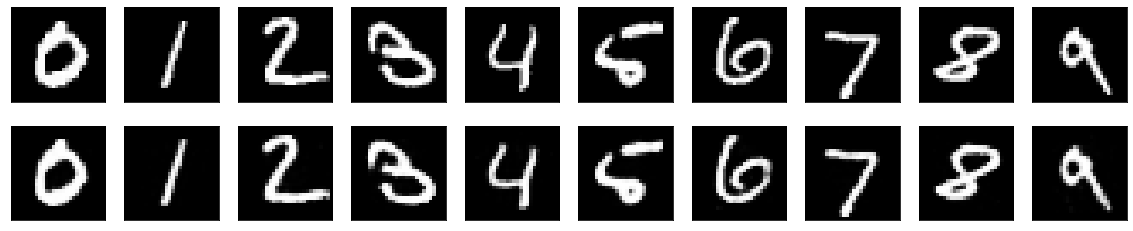

In [34]:
plt.figure(figsize=(20, 4))
Y = ae.forward(Xtest)
indices = []
indices = [options[0][0] for options in [np.where(Ytest==i) for i in range(10)]]
for count,i in enumerate(indices):
    # Display original
    ax = plt.subplot(2, 10, count + 1)
    plt.imshow(Xtest[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, count + 1 + 10)
    plt.imshow(np.transpose(Y)[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [16]:
(FXtrain,_), (FXtest,FYtest) = fashion_mnist.load_data()
FXtrain = FXtrain.astype("float32") / 255.
FXtest = FXtest.astype("float32") / 255.
FXtrain = FXtrain.reshape((len(FXtrain), np.prod(FXtrain.shape[1:])))
FXtest = FXtest.reshape((len(FXtest), np.prod(FXtest.shape[1:])))
d = FXtrain.shape[1]
n1 = 100
print(FXtrain.shape)
print(FXtest.shape)

(60000, 784)
(10000, 784)


In [34]:
fae = autoencoder(d,n1)

In [35]:
from time import time
numepochs = 15
ntrain = FXtrain.shape[0]
numsplits = 600
print(f"Xbatch size: {ntrain//numsplits}")
e = 0
loss = 1
while e < numepochs:
    epoch_start = time()
    start = time()
    loss = fae.loss(FXtrain)
    print(f"Training loss [{'#'*(e+1)}{'.'*(numepochs-e-1)}]:\n\t{loss:.2f} calculated in {time()-start:.2f} seconds")
    minibatches = np.split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = FXtrain[indices, :]
        fae.forward(Xbatch)
        fae.backward()
        fae.adam_step(alpha=0.005, rho1=0.5, rho2=0.9, delta=1e-4)
    print(f"Epoch {e+1} took {time()-epoch_start:.2f} seconds to run")
    e += 1

Xbatch size: 100
Training loss [#..............]:
	0.90 calculated in 5.88 seconds
Epoch 1 took 13.15 seconds to run
Training loss [##.............]:
	0.29 calculated in 6.68 seconds
Epoch 2 took 15.21 seconds to run
Training loss [###............]:
	0.28 calculated in 5.31 seconds
Epoch 3 took 20.63 seconds to run
Training loss [####...........]:
	0.28 calculated in 7.07 seconds
Epoch 4 took 20.86 seconds to run
Training loss [#####..........]:
	0.27 calculated in 5.78 seconds
Epoch 5 took 13.95 seconds to run
Training loss [######.........]:
	0.27 calculated in 8.21 seconds
Epoch 6 took 19.21 seconds to run
Training loss [#######........]:
	0.27 calculated in 5.32 seconds
Epoch 7 took 15.36 seconds to run
Training loss [########.......]:
	0.27 calculated in 6.62 seconds
Epoch 8 took 15.97 seconds to run
Training loss [#########......]:
	0.27 calculated in 5.16 seconds
Epoch 9 took 14.21 seconds to run
Training loss [##########.....]:
	0.27 calculated in 4.68 seconds
Epoch 10 took 12.

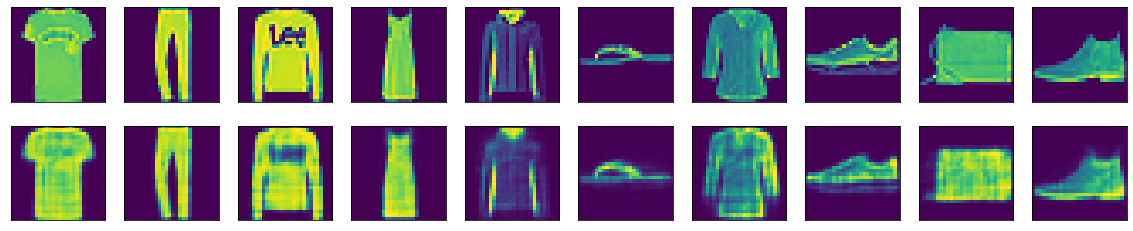

In [36]:
plt.figure(figsize=(20, 4))
Y = fae.forward(FXtest)
indices = []
indices = [options[0][0] for options in [np.where(FYtest==i) for i in range(10)]]
for count,i in enumerate(indices):
    # Display original
    ax = plt.subplot(2, 10, count + 1)
    plt.imshow(FXtest[i].reshape(28, 28))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, count + 1 + 10)
    plt.imshow(np.transpose(Y)[i].reshape(28, 28))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
